In [5]:
import wandb
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
plt.rcParams['figure.dpi'] = 100
import runs_store as rs

In [6]:
perf_runs = {}
for p in ["alpha", "hpdlf", "gpu2"]:
    runs = rs.load_runs(f"../data/runs/orlopau/{p}/batch_speed_perf.pickle")
    run = rs.reduce_runs(runs)
    # join values in dataframe based on column "batch_size"
    run = run.groupby(run["batch_size"]).aggregate("mean").reset_index()
    perf_runs[p] = run

perf_runs["alpha"].head()

,batch_size,epoch,nodes,gpus,size,time_epoch_med,time_train_med,time_test_med,time_sync_med,time_sync_sum_med,acc_test_min,acc_train_min,time_train_min,gpu_power,gpu_usage,gpu_mem,gpu_mem_usage
0,75,9.0,1.0,1.0,1.0,42.293591,37.101669,5.191918,0.001294,12.937422,0.002058,0.001508,36.567677,17.827634,17.989822,4.607532,0.830789
1,89,9.0,1.0,1.0,1.0,36.843312,32.313910,4.529397,0.001426,12.013443,0.001105,0.001536,31.475650,17.103559,17.676471,4.649294,0.838235
2,106,9.0,1.0,1.0,1.0,32.567788,28.622013,3.945772,0.001631,11.536004,0.001232,0.001533,28.455533,16.691993,17.252669,4.650000,0.830961
3,126,9.0,1.0,1.0,1.0,28.506207,24.979663,3.526540,0.001837,10.935743,0.001774,0.002083,24.737952,19.224696,18.066802,4.659190,0.868421
4,151,9.0,1.0,1.0,1.0,24.760862,21.586281,3.174576,0.001962,9.745433,0.002613,0.003150,21.469886,19.161783,15.858696,4.650000,0.804348


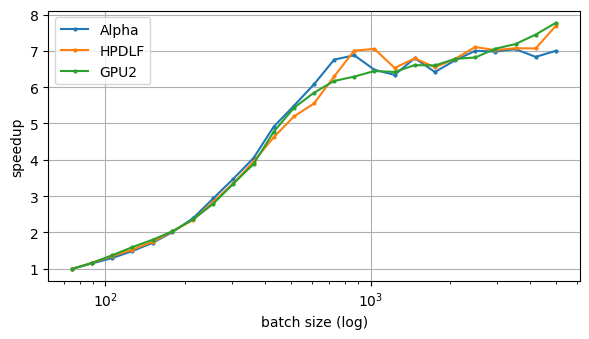

In [9]:
def plot_speedup(run_dfs):
    fig, ax = plt.subplots(1, figsize=(6,3.5))

    for name, df in run_dfs.items():
        df = df.sort_values(by="batch_size", ascending=True).reset_index(drop=True)
        x = df["batch_size"]
        y = df["time_train_med"]

        ax.plot(x, y[0]/y.to_numpy(), label=f"{name}", linewidth=1.5, marker="o", markersize=2)

    ax.set_ylabel("speedup")
    ax.legend()

    ax.grid()
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_xlabel("batch size (log)")
    ax.set_xscale("log")

    fig.tight_layout()
    return fig, ax

def plot_batch_epoch_time(run_dfs):
    """
    Plots the time per epoch and speedup vs the batch size.
    """

    fig, axs = plt.subplots(2, figsize=(6,6), sharex=True)
    fig.suptitle("Epoch Time vs. Batchsize of 75 to 5000")

    (ax_time, ax_speed) = axs
    for name, df in run_dfs.items():
        df = df.sort_values(by="batch_size", ascending=True).reset_index(drop=True)
        x = df["batch_size"]
        y = df["time_train_med"]

        ax_speed.plot(x, y[0]/y.to_numpy(), label=f"{name}", linewidth=1.5, marker="o", markersize=2)
        ax_time.plot(x, y, label=f"{name}", linewidth=1.5, marker="o", markersize=2)

    ax_time.set_ylabel("time per epoch (s)")
    axs[0].legend()
    ax_speed.set_ylabel("speedup")

    for ax in axs:
        ax.grid()
        ax.set_xlabel("batch size")
        ax.set_xscale("log")

    fig.tight_layout()
    fig.savefig("./plots/batch_time.png", dpi=300)
    return fig, axs

def plot_batch_gpu(run_dfs):
    """
    Plots the gpu usage vs the batch size.
    """
    
    fig, axs = plt.subplots(2, figsize=(6,6), sharex=True)
    fig.suptitle("GPU Usage vs. Batchsize of 75 to 5000")

    (ax_gpu, ax_gpu_watt) = axs
    for name, df in run_dfs.items():
        df = df.sort_values(by="batch_size", ascending=True).reset_index(drop=True)
        x = df["batch_size"]

        ax_gpu.plot(x, df["gpu_usage"], label=f"{name}", linewidth=1.5, marker="o", markersize=2)
        ax_gpu_watt.plot(x, df["gpu_power"], label=f"{name}", linewidth=1.5, marker="o", markersize=2)

    ax_gpu_watt.set_ylabel("gpu power (%)")
    axs[0].legend()
    ax_gpu.set_ylabel("gpu usage (%)")

    for ax in axs:
        ax.grid()
        ax.set_xlabel("batch size (log)")
        ax.set_xscale("log")
        ax.set_ylim(0, 100)

    fig.tight_layout()
    return fig, axs

fig, ax = plot_speedup(perf_runs)
ax.lines[0].set_label(ax.lines[0].get_label().capitalize())
ax.lines[1].set_label(ax.lines[1].get_label().upper())
ax.lines[2].set_label(ax.lines[2].get_label().upper())
ax.legend()
fig.tight_layout()
fig.savefig("./plots/batch_time.png", dpi=300)